# Relative Word Frequencies

## Skills

1. Tokenize data using the tidytext module.
2. Cleanse text data.
2. Analyze a document using its most frequent words.
3. Visualize a text using word clouds.
4. **Compare paired documents using relative frequencies.**
5. Use TF-IDF to examine word frequencies in groups of documents.
6. Use TF-IDF to define context-dependent stop words.

## Vocabulary List

**data pipeline.** A series of steps taken from the point data are recorded to its final, processed stage, which may include visualizations or other summary statistics. Data pipelines are common not only for NLP but more generally in data science.

**logarithm.** A way to transform data that allows you to compare numbers across very different scales easily. The number 1 has a logarithm of 0, which is extremely useful for "zeroing out" common words in TF-IDF analysis. Additionally, $\log(1/2) = -\log(2/1)$, which is useful for looking at relative frequencies.

**stop words.** Extremely common words which don't give insight into a document, from a word-level analysis.

**TF-IDF.** Text-frequency inverse document-frequency. A way of picking out the most common words in a text that are unique to that text.

In [ ]:
# I'm going to start commenting out unused libraries, but leave them in
# So you have a complete list of the libraries we've used in this class.
#import urllib.request
#from wordcloud import WordCloud, STOPWORDS
from wordcloud import STOPWORDS

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# The tidytext package isn't in Google Colaboratory's default list of packages, so we install it first
!pip install tidytext
import tidytext
# This library is used by tidytext for tokenization
import nltk
nltk.download('punkt')

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.6/208.6 kB 3.4 MB/s eta 0:00:00
  Created wheel for tidytext: filename=tidytext-0.0.1-py3-none-any.whl size=3870 sha256=baf56191b030cf38a9a1b9793136e1942c97af1870eb5f66fe66fa9178993478
  Stored in directory: /root/.cache/pip/wheels/88/40/40/04f8d22d7729547afa13c2cbffb494737351dd4465f2f26288
Successfully built tidytext


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Intro

In the previous notebook, we considered a single text, and looked at the word counts. Here, we're going to compare the counts in two different documents (or two groups of documents), and look where words are more common. Some questions we may be interested in:

* If we compare the works of two authors (artists, poets, ...), how do their vocabularies differ?
* How do the words used in positive product reviews differ from negative product reviews?
* Are certain words more common in one music genre over another?
* *How are decriptions of Netflix movies and TV shows different? Are some words more common in one or the other?*

This last one is what we'll be investigating today. We'll do that by breaking the word counts into two groupings, then a bit of data manipulation and some data visualization.

### Frequencies vs. Counts

Today, we're going to be more interested in the frequency that a word shows up, rather than its raw counts. So, for example, I care whether a word shows up once every 100 words rather than it appearing in a document 5 times. Why? Because a longer document will naturally have more words in it, so to compare between documents we need to take that into account. So, instead of the raw counts, we'll calculate the *text frequency*:

$$TF = \text{text frequency} = \frac{\text{# of times }word\text{ appears in a document}}{\text{total words in the document}}$$

Luckily, pandas does this for us when we add call `.count_values()` with the argument `normalize=True`. We then will calculate the relative frequency between two documents:

$$RF = \text{relative frequency} = \frac{TF \text{ document 1}}{TF \text{ document 2}}$$

### Log Ratio

Finally, we'll be taking a logarithm of these. Why? Because we want a $RF$ of $1/4$ to appear the same on a graph as a $RF$ of $4/1$: both represent a 4-to-1 ratio, it just depends on which document has more counts. Here is a visualization of several different ratios without transformation (left) and a log transformation (right):

<div style="text-align:center;"><img src="https://imgur.com/BxEAbMo.png"> <img src="https://imgur.com/59HkS1M.png"></div>

### Processing the Input

Let's load in the dataset into a dataframe.

In [ ]:
netflix = pd.read_csv("https://raw.githubusercontent.com/Greg-Hallenbeck/HARP-210-NLP/main/pandas/netflix.csv")
netflix.head(2)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,48,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,113,"['crime', 'drama']",['US'],NaN,tt0075314,8.3,795222.0,27.612,8.2


The datasets from 3.1. were individual strings, but this is a dataframe with many strings, which simplifies things significantly.

In [ ]:
df = tidytext.unnest_tokens(netflix, "word", "description")

For relative word counts, we'll just be looking at some binary category. Here, we'll use type, since it has two values: "SHOW" and "MOVIE", but we could also look at media released before and after 2000, or one with "TV-MA" and "R" ratings versus others. To simplify things, I'm going to throw out all columns except that category and the words.

In [ ]:
df = df[["type", "word"]]

df.head(100)

,type,word
0,SHOW,this
0,SHOW,collection
0,SHOW,includes
0,SHOW,12
0,SHOW,world
...,...,...
2,MOVIE,way
2,MOVIE,arthur
2,MOVIE,battles
2,MOVIE,the


### Word Counting
First, we remove stop words:

In [ ]:
clean_words = df.loc[ ~df["word"].isin(STOPWORDS) ]

Then count them, just as we did before (after some grouping)

In [ ]:
counts = clean_words.groupby("type")["word"].value_counts(normalize=True)

A quick inspection of the `counts` variable shows that there's some extremely rare text that we...probably don't want to keep. Let's remove anything with a very low frequency.

In [ ]:
counts

type   word          
MOVIE  life              0.006755
       ’                 0.004893
       love              0.004757
       one               0.004609
       family            0.004541
                           ...   
SHOW   —and              0.000022
       —living           0.000022
       ベイブレードバーストgtガチ    0.000022
       非天夜翔              0.000022
       麻婆斗妇              0.000022
Name: word, Length: 30674, dtype: float64

In [ ]:
# keep anything with a count > 0.0005
counts = counts[counts > 0.0005]

...and then convert it back to a dataframe.

In [ ]:
counts.name = "text_freq"
counts = counts.reset_index()

In [ ]:
counts.head()

,type,word,text_freq
0,MOVIE,life,0.006755
1,MOVIE,’,0.004893
2,MOVIE,love,0.004757
3,MOVIE,one,0.004609
4,MOVIE,family,0.004541


### Relative Frequency

This requires us to use one function that I haven't shown you: `DataFrame.pivot()`. It will let us directly compare the movie and TV show entries. Some [hopefully helpful documentation](https://pandas.pydata.org/docs/user_guide/reshaping.html) can be found here.

In [ ]:
counts = counts.pivot(index='word', columns='type', values='text_freq')
counts = counts.reset_index()

In [ ]:
counts.head()

type,word,MOVIE,SHOW
0,across,0.000511,0.000556
1,adventure,0.000636,0.000734
2,adventures,NaN,0.001602
3,ago,NaN,0.000667
4,along,0.000647,0.000667


Then we fill in all the NAs with something below the minimum value for that type of media.

In [ ]:
counts.loc[counts["MOVIE"].isna(), "MOVIE"] = counts["MOVIE"].min()/2
counts.loc[counts["SHOW"].isna(), "SHOW"]  = counts["SHOW"].min()/2

And calculate the movie/show word ratio, then a $\log($ratio$)$

In [ ]:
# column ratio should be the TF for MOVIE divided by TF for SHOW
counts["ratio"] = counts["MOVIE"]/counts["SHOW"]
counts["logratio"] = np.log10(counts["ratio"])

And finally, sort, so that we can see the words most strongly associated with movies and TV shows.

In [ ]:
counts = counts.sort_values("logratio", ascending=True)

### Visualization

Now we've got a sorted DataFrame, which we can simply use to make a plot.

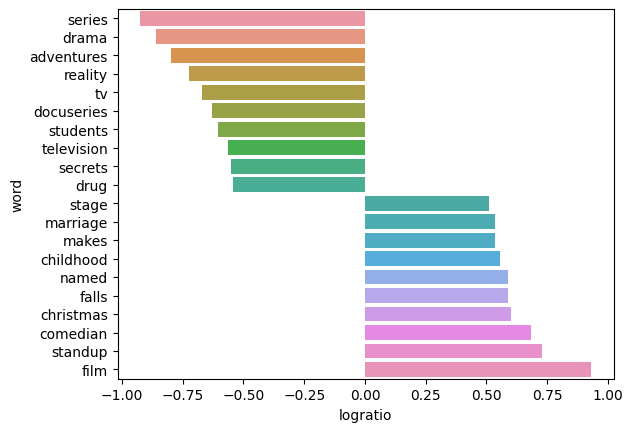

In [ ]:
firstlast = pd.concat([  counts[0:10] , counts[-10:]  ])

# What kind of plot should I use?
sns.barplot(data=firstlast, x="logratio", y="word")
plt.show()

What words are most strongly associated with movie descriptions? With TV shows? Why?